<a href="https://colab.research.google.com/github/jecampagne/cours_mallat_cdf/blob/main/cours2024/ScoreDiffusionGene.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from matplotlib import pyplot as plt, cm
from matplotlib import colors

In [3]:
import numpy as np
from scipy.stats import norm

In [4]:
import jax
import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap
from jax import jacfwd, jacrev, hessian
jax.config.update("jax_enable_x64", True)

In [5]:
jax.__version__

'0.4.23'

In [11]:
# !pip install -q jaxopt  numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 2.7 MB/s eta 0:00:00


In [8]:
import jaxopt
import optax
from jaxopt import OptaxSolver

In [12]:
import numpyro
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import HMC, NUTS,  BarkerMH,  MCMC, init_to_sample

In [13]:
numpyro.__version__

'0.13.2'

In [14]:
import tensorflow_probability as tfp

# Illustration de génération via Score Matching Diffusion Model

Dans ce notebook, on va se cantoner à un problème en 1D. Les données $x_0$ sont issues d'une pdf sous forme distribution de Gibbs
$$
\Large p(x) = Z^{-1} \exp\{-U(x) \}
$$
où $U(x)$ joue le rôle d'une énergie que l'on a choisi dans la famille
$$
\Large U(x;\theta) = \frac{1}{2} \mu x^2  + \frac{1}{4} \beta x^4
$$
Pour $x_0\sim p_0$, les paramètres sont $\theta = (\mu,b)=(-4,1)$, ce qui donne une distribution avec 2 puits de potentiel attracteurs assez distincts (type $\lambda \phi^4$ en dessous de la température critique). Notons qu'ici $p_0$ a une expression connue et non utilisons un MCMC de type Mamiltonian Monte Carlo pour produire les échantillons, mais  par exemple concernant la génération d'images, nous n'avons à disposition qu'un seul dataset.

De là on peut faire opérer (**Forward process**) équation différentielle stochastique (EDS ou SDE en anglais) qui a l'instant $t$ s'écrit:
$$
\Large dx_t = -x_t dt +\sqrt{2} dw_t
$$
avec $x_t$ les échantillons et $dw_t$ un processus de Wigner (mvt Brownien). La solution étant
$$
\Large x_t = e^{-t}x_0 + (1-e^{-2t})^{1/2} z, \quad z \overset{iid}{\sim} \mathcal{N}(0,\mathbf{1})
$$
Notons que la moyenne $\mu_t$ et la variance $\Sigma_t$ de $x_t$ s'esprime en fonction de $(\mu_0, \Sigma_0)$ leurs valeurs initiales:
$$
\begin{align}
\mu_t &= e^{-t} \mu_0 \\
\Sigma_t &= e^{-2t} \Sigma_0 + (1-e^{-2t}) \mathbf{1}
\end{align}
$$
Progressivement, la distribution des $x_t$ devient une gaussienne cenrée normée ($x_\infty \sim \mathcal{N}(0,\mathbf{1})$). Remarquons que si $p_0$ était une gaussienne centrée de variance $\sigma^2$, on pourrait facilement en déduire l'expression de $p_t$ (qui en fait une probabilité conditionelle $p_{0\rightarrow t}(x_t|x_0)$). D'une manière générale, on aurait à résoudre une équation de Kolmogorov.

Le point intéressant la **génération** de nouveaux échantillons de type $x_0$, notés $\tilde{x}_0$, est que  l'on peut inverser le processus stochastique (**Bacward process**) qui est une nouvelle SDE. On peut discrétiser la SDE par exemple en considérant des pas d'intervalle constant $t_k = T - k\delta$ avec $k=0,1,\dots, n_s$ et  $T/n_s=\delta$:
$$
\Large \tilde{x}_{t_{k+1}} = \left( \tilde{x}_{t_{k}} + 2\times  \nabla_x \log p_{t_{k}}(\tilde{x}_{t_{k}}) \right)\delta +  \sqrt{2\delta}\  z_k; \quad  z_k \overset{iid}{\sim} \mathcal{N}(0,\mathbf{1})
$$
On commence le processus de génaration avec $x_T\sim  \mathcal{N}(0,\mathbf{1})$ pour un temps $T>0$.

C'est l'estimation de $\nabla_x \log p_{t_{k}}(\tilde{x}_{t_{k}})$ qui poserait problème dans ce schéma. Pour cela on va utiliser le **Score Matching**. Soit un lot de $N$ données $x$ tirées a priori selon une pdf $p(x)$ et soit une famille de pdf paramétrées $\{p_\theta (x)\}_\theta$. Soit alors
$$
\psi(x,\theta) = \nabla_x \log p_\theta(x)
$$
Le meilleur $\theta$, noté $\theta^\ast$ correspond à
$$
\theta^\ast = \underset{\theta}{\mathrm{argmin}}\ \underbrace{\mathbb{E}_{x\sim p}\left[ \frac{1}{2}\|\psi(x,\theta) \|^2_2 + \nabla\bullet \psi(x,\theta)\right]}_{J(\theta)}
$$
On estime l'espérance en utilisant la moyenne sur les données, ainsi la fontion à minimiser est (imaginons que l'on est $d$ dimensions un instant où $\psi=(\psi_1,\psi_2,\dots,\psi_d)$ et la $j$-ieme donnée est $x^{(j)}=(x^{(j)}_1,\dots,x^{(j)}_d)$):
$$
\Large \bar{J}(\theta) = \frac{1}{N}\sum_{j=1}^N \sum_{i=1}^d \left[\frac{1}{2}\psi_i^2(x^{(j)},\theta) +
\partial_{x_i} \psi_i(x^{(j)},\theta)\right]
$$
Notez l'atout au passage de la méthode, et de ne pas avoir à calculer la constante de normalisatiin de $\log p_\theta(x)$.

Appliqué à la génération, à l'étape $t=t_k$ les données sont obtenue  à partir des $x_0$ en utilsiant le mode Forward. Puis comme modèle paramétré, on utlise le modèle de Gibbs décrit ci-dessus qui donne
$$
\Large \psi(x,\theta) = - U(x,\theta)
$$
Et une fois l'optilisation faite $\theta = \theta^\ast_{t_{k}}$ et donc
$$
\Large \nabla_x \log p_{t_{k}}(\tilde{x}_{t_{k}}) \approx \psi(\tilde{x}_{t_{k}},\theta^\ast_{t_{k}})
$$






In [15]:
@jit
def iv(nu, x):
    """Modified Bessel 1st kind"""
    nu = 1.0 * nu
    x = 1.0 * x
    return tfp.substrates.jax.math.bessel_ive(nu, x) * jnp.exp(jnp.abs(x))

@jit
def kv(nu, x):
    """Modified Bessel 2nd kind"""
    nu = 1.0 * nu
    x = 1.0 * x
    return tfp.substrates.jax.math.bessel_kve(nu, x) / jnp.exp(jnp.abs(x))

@jit
def gamma(x):
    """Gamma(x)"""
    x = x * 1.0
    return jnp.exp(jax.lax.lgamma(x))

In [16]:
@jit
def U(x,params):
    mu, b = params
    return 0.5 * mu * x*x + 0.25 * b * x*x*x*x

In [17]:
#b>0
@jit
def _fZpos(mu,b):
    mu2 = mu * mu * 0.125/b # mu^2/(8b)
    return jnp.exp(mu2)*jnp.sqrt(mu*0.5/b)*kv(0.25,mu2)

@jit
def _fZneg(mu,b):
    mu2 = mu * mu * 0.125/b # mu^2/(8b)
    c = jnp.pi * 0.5
    return jnp.exp(mu2)*jnp.sqrt(-mu/b)* c * (iv(0.25,mu2) + iv(-0.25,mu2))

@jit
def _Z(mu,b):
    b = jnp.abs(b) + 1.0e-10 # protection b>0
    return jnp.select([mu>0,mu<0],
                      [_fZpos(mu,b),_fZneg(mu,b)],
                      default=gamma(0.25)/jnp.sqrt(2.0*jnp.sqrt(b)))

In [18]:
@jit
def _logpdf(x,mu,b=1.0): #only with b=1
    return -jnp.log(_Z(mu,b)) -  U(x,jnp.array([mu,b]))

@jit
def _pdf(x,mu, b=1.0):
    return jnp.exp(_logpdf(x,mu,b))

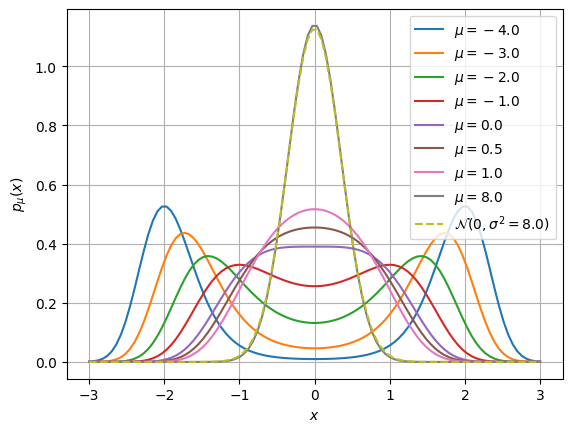

In [19]:
xvals = jnp.linspace(-3,3,100)
for mu in [-4.,-3., -2., -1.,0., 0.5, 1.,8.]:
    plot(xvals,_pdf(xvals,mu),label=fr"$\mu = {mu}$")
sigma = 1/jnp.sqrt(mu)
plot(xvals,jnp.exp(-0.5*(xvals/sigma)**2)/jnp.sqrt(2*jnp.pi*sigma**2),ls='--',label=fr"$\mathcal{{N}}(0,\sigma^2={mu})$")
grid()
xlabel("$x$")
ylabel(r"$p_\mu(x)$")
legend();

In [20]:
@jit
def _psi(x,params): # grad logpdf
    return -grad(U)(x,params)

_vpsi = jit(vmap(_psi,in_axes=(0,None))) # vectorize along x

@jit
def _gradpsi(x,params):
    return grad(_psi)(x,params)

_vgradpsi = jit(vmap(_gradpsi,in_axes=(0,None))) # vectorize along x


# Echantillon initial $x_0$ ($\mu=-4, b=1$) : usage d'un MCMC Hamiltonien

In [21]:
mu_orig = -4.0

# get samples
rng_key = jax.random.PRNGKey(42)
_, rng_key = jax.random.split(rng_key)

# Use a HMC
kernel = HMC(potential_fn=lambda x: -_logpdf(x,mu_orig))  # negative log
num_samples = 100_000
n_chains    = 3
mcmc = MCMC(kernel, num_warmup=2_000, num_samples=num_samples,
            num_chains=n_chains,chain_method='vectorized',
            progress_bar=False) # progress_bar=True ralentit bcq... donc ok pour num_samples=1000.
mcmc.run(rng_key, init_params=jnp.zeros(n_chains))
mcmc.print_summary()
samples_1 = mcmc.get_samples().squeeze()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Param:0      0.03      1.92      0.57     -2.36      2.36   2086.07      1.00

Number of divergences: 0


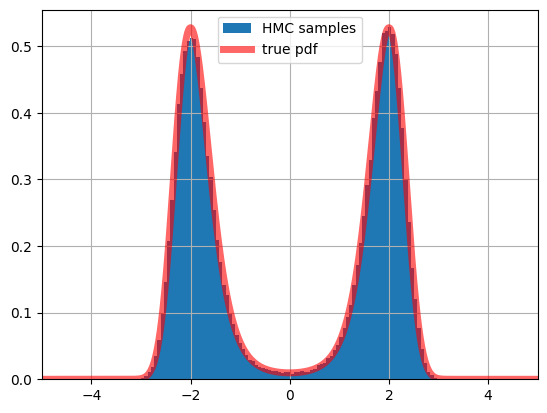

In [22]:
x_axis = np.arange(-5, 5, 0.01)
hist(samples_1, bins=100, density=True, label="HMC samples");
plot(x_axis, _pdf(x_axis,mu_orig),'r-', lw=5, alpha=0.6, label='true pdf')
xlim([-5,5])
#yscale('log')
grid()
legend();

# Diffusion model

$$
\Large x(t) = x_0 e^{-t} + (1-e^{-2t})^{1/2} z \qquad z \sim \mathcal{N}(0,1)
$$

$x_0$ represent the original dataset

In [23]:
Nsamples = 100_000
x0 = samples_1[-Nsamples:]
Nspls = len(x0)

In [24]:
#pour suivre 10 chaines de Markov
rnd_idx = numpy.arange(Nsamples)
np.random.shuffle(rnd_idx)
rnd_idx = rnd_idx[:10]

In [25]:
# définition de T (ici T_max) et de dt connaissant le nombre de steps
T_max = 2
n_steps = 200
dt = T_max/n_steps

## Forward diffusion process

In [26]:
all_xk_bin=[]
track_fwd=[]
for k in range(0,n_steps+1):
    tk = k * dt
    _, rng_key = jax.random.split(rng_key)
    z = jax.random.normal(rng_key,shape=(Nspls,))
    xk = x0 * jnp.exp(-tk) + jnp.sqrt(1-jnp.exp(-2*tk))*z
    track_fwd.append(xk[rnd_idx])
    n,bins= np.histogram(xk, bins=100, density=True, range=[-4,4])
    all_xk_bin.append(n)
all_xk_bin = np.array(all_xk_bin)

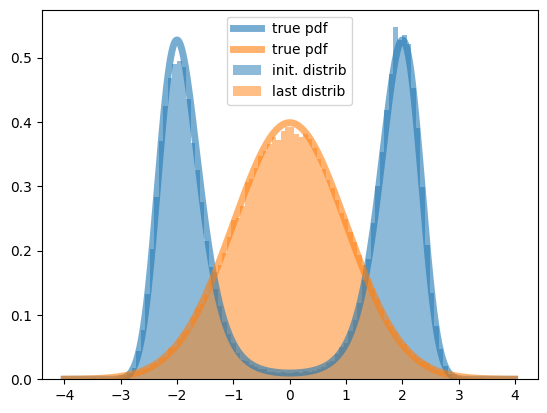

In [27]:
x_axis = np.arange(-4, 4, 0.01)
bar(bins[:-1], all_xk_bin[0], width=np.diff(bins), align="edge", alpha=0.5, label="init. distrib")
plot(x_axis, _pdf(x_axis,mu_orig), lw=5, alpha=0.6, label='true pdf')


bar(bins[:-1], all_xk_bin[-1], width=np.diff(bins), align="edge", alpha=0.5, label="last distrib")
plot(x_axis, norm.pdf(x_axis), lw=5, alpha=0.6, label='true pdf')
legend();

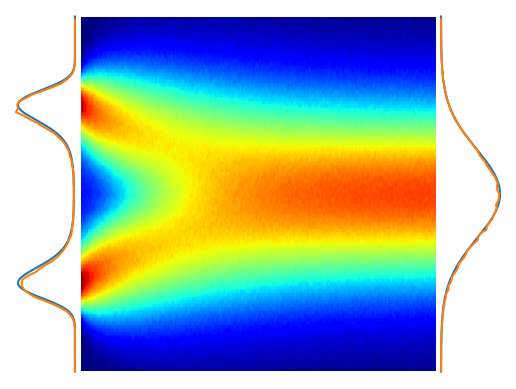

In [28]:
x_axis = np.arange(-4, 4, 0.01)

gkw = {'width_ratios':[1, 5, 1] }
fig, (ax0, ax1, ax2) = subplots(1, 3,  gridspec_kw = gkw )
fig.figsize=(15,7)

#vert_hist = np.histogram(sample, bins=30)
#ax1 = plt.subplot(2, 1, 1)
#ax1.plot(vert_hist[0], vert_hist[1][:-1], '*g')



ax0.plot(-_pdf(x_axis,mu_orig),x_axis)
ax0.plot(-all_xk_bin[0],bins[:-1]) #all_xk_bin[0])#, width=np.diff(bins))#, align="edge", alpha=0.5, label="init. distrib")

ax1.imshow(all_xk_bin.T,cmap='jet',norm=colors.PowerNorm(0.5), extent=[0,1,0,1])
#ax1.plot(track0,c='b')
ax2.plot(norm.pdf(x_axis),x_axis)
ax2.plot(all_xk_bin[-1],bins[:-1]) #all_xk_bin[0])#, width=np.diff(bins))#, align="edge", alpha=0.5, label="init. distrib")

for ax in fig.get_axes():
    ax.set(xticks=[], yticks=[])
    ax.axis('off')
    ax.margins(x=0.1,y=0.02)
plt.subplots_adjust(wspace=0, hspace=0)

## Bakward process: phase de génération

In [29]:
# J(theta)
@jit
def score(params,data=jnp.array([0.])):
    xdata = jnp.atleast_1d(data)
    norm = _vpsi(xdata,params)
    sqnorm = 0.5 * norm**2
    div = _vgradpsi(xdata,params)
    return jnp.mean(sqnorm + div)

In [30]:
_, rng_key = jax.random.split(rng_key)
init_params = jnp.array([0.,1.])

In [31]:
# solver pour minimiser la fonction J(theta) et trouver le theta optimal
maxiter=1000
solver = jaxopt.ScipyMinimize(fun=score, method="L-BFGS-B", maxiter=maxiter)

In [32]:
#test solver 1
res0 = solver.run(init_params,data=x0)
print(f"(mu,b) from solver: {res0.params}  vs mu_orig={mu_orig} and b_orig=1")

(mu,b) from solver: [-4.00331374  0.99850132]  vs mu_orig=-4.0 and b_orig=1


(mu,b) from solver: [0.94746783 0.0041957 ]  vs std normal distrib. mu=1.0 and b=0.0


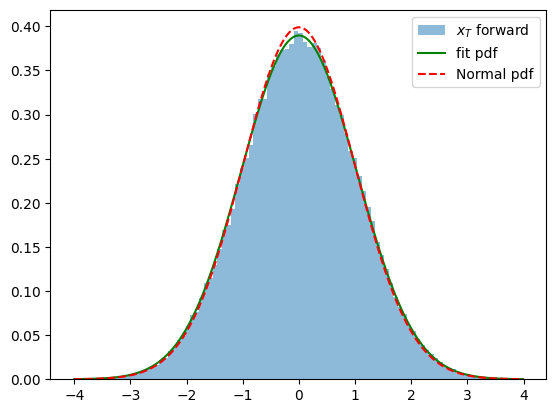

In [33]:
#test solver 2
resk = solver.run(init_params,data=xk)
print(f"(mu,b) from solver: {resk.params}  vs std normal distrib. mu=1.0 and b=0.0")
x_axis = np.arange(-4, 4, 0.01)
hist(xk,bins=100,density=True,alpha=0.5, label = r"$x_T$ forward")
muk,bk=resk.params
plot(x_axis, _pdf(x_axis,muk,bk),c="g",label="fit pdf")
plot(x_axis,norm.pdf(x_axis),ls="--",c='r', label="Normal pdf")
legend();

In [34]:
_, rng_key = jax.random.split(rng_key)
xBwd = jax.random.normal(rng_key,shape=(Nspls,))  # init

all_xk_bwd_bin=[]
n,bins= np.histogram(xBwd, bins=100, density=True, range=[-4,4])
all_xk_bwd_bin.append(n)

track_bwd=[] # pour suivre des chaines de Markov lors de la progression
track_bwd.append(xBwd[rnd_idx])

for k in range(1,n_steps+1):
    tkBwd = T_max - k * dt
    # estimation of theta^* parameter to determine psi(.,theta^*)
    # this is done in the forward pass
    _, rng_key = jax.random.split(rng_key)
    zFwd = jax.random.normal(rng_key,shape=(Nspls,))
    xkFwd = x0 * jnp.exp(-tkBwd) + jnp.sqrt(1-jnp.exp(-2*tkBwd))*zFwd
    resk = solver.run(init_params,data=xkFwd)
    paramsk = resk.params
    # new backward samples
    _, rng_key = jax.random.split(rng_key)
    zBwd = jax.random.normal(rng_key,shape=(Nspls,))
    xBwd = xBwd + dt * (xBwd + 2.0 * _vpsi(xBwd, paramsk)) + jnp.sqrt(2*dt)*zBwd
    n,bins= np.histogram(xBwd, bins=100, density=True, range=[-4,4])
    all_xk_bwd_bin.append(n)
    track_bwd.append(xBwd[rnd_idx])

all_xk_bwd_bin = np.array(all_xk_bwd_bin)

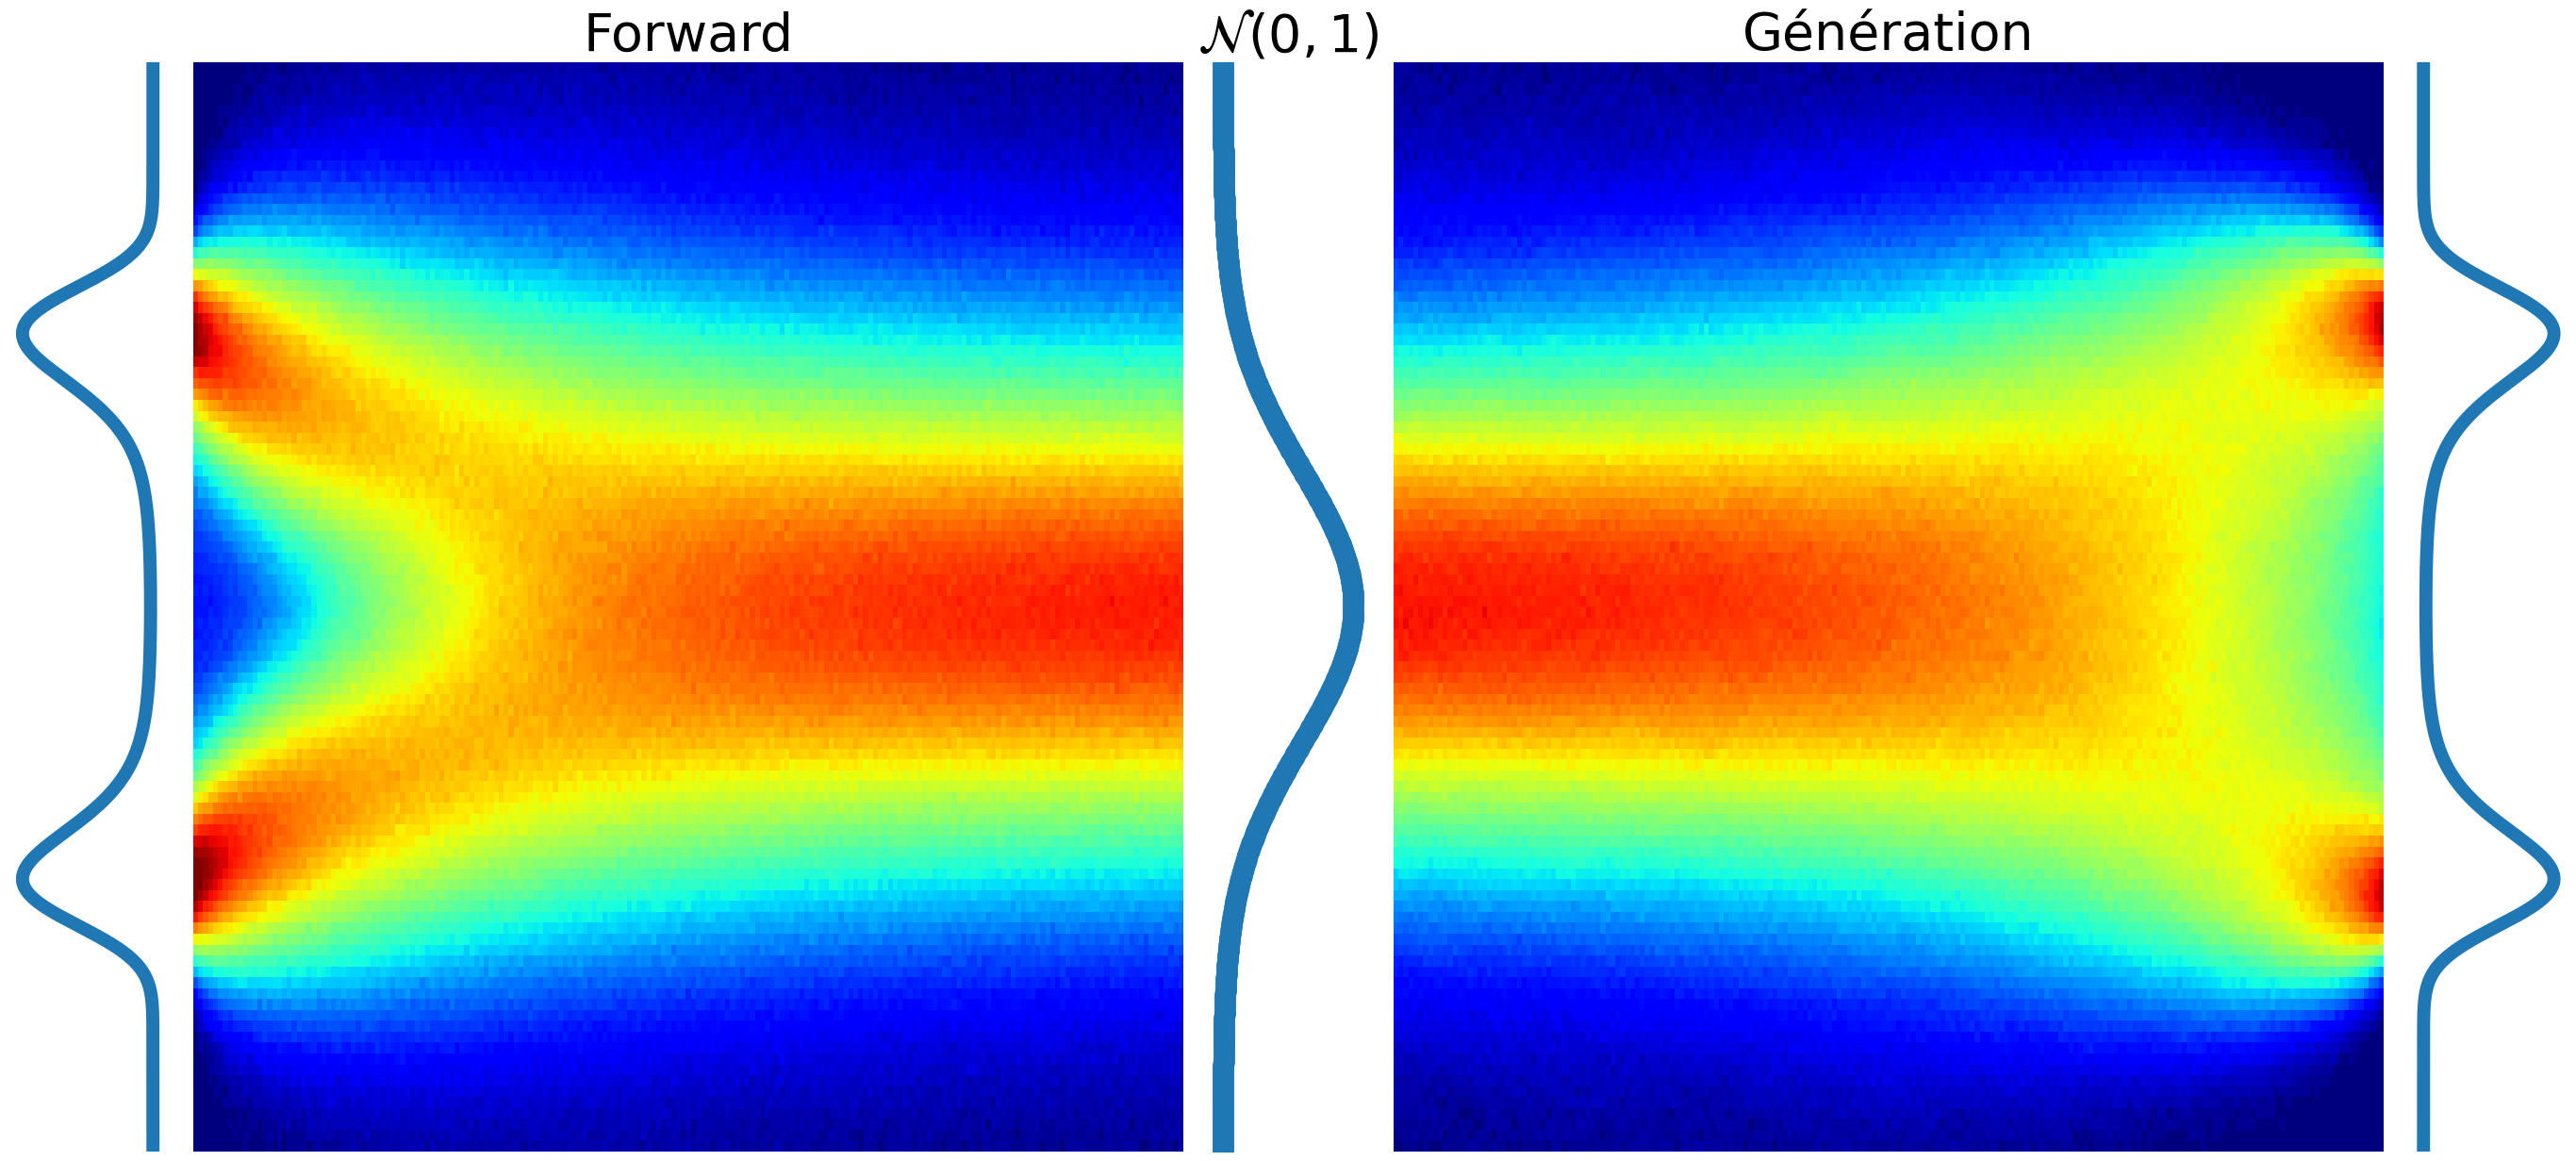

In [35]:
x_axis = np.arange(-4, 4, 0.01)

gkw = {'width_ratios':[1.5, 10, 1.5, 10, 1.5] }
fig, (ax0, ax1, ax2, ax3, ax4) = subplots(1, 5,  gridspec_kw = gkw, figsize=(35,15) )



ax0.plot(-_pdf(x_axis,mu_orig),x_axis,lw=10)
#ax0.plot(-all_xk_bin[0],bins[:-1]) #all_xk_bin[0])#, width=np.diff(bins))#, align="edge", alpha=0.5, label="init. distrib")

ax1.imshow(all_xk_bin.T,cmap='jet',norm=colors.PowerNorm(0.5,vmin=0, vmax=0.5), extent=[0,1,0,1.1])
#ax1.plot(track0,c='b')
ax2.scatter(norm.pdf(x_axis),x_axis,lw=10)
#ax2.plot(all_xk_bin[-1],bins[:-1]) #all_xk_bin[0])#, width=np.diff(bins))#, align="edge", alpha=0.5, label="init. distrib")

ax3.imshow(all_xk_bwd_bin.T,cmap='jet',norm=colors.PowerNorm(0.5,vmin=0, vmax=0.5), extent=[0,1,0,1.1])

ax4.plot(_pdf(x_axis,mu_orig),x_axis,lw=10)
#ax4.plot(all_xk_bwd_bin[-1],bins[:-1]) #all_xk_bin[0])#, width=np.diff(bins))#, align="edge", alpha=0.5, label="init. distrib")

ax1.set_title("Forward",fontsize=40)
ax2.set_title(r"$\mathcal{{N}}(0,1)$",fontsize=40)
ax3.set_title("Génération",fontsize=40)

for ax in fig.get_axes():
    ax.set(xticks=[], yticks=[])
    ax.axis('off')
    ax.margins(x=0.1,y=0.)
plt.subplots_adjust(wspace=0, hspace=0)

In [36]:
track_fwd = np.array(track_fwd)

In [37]:
track_bwd = np.array(track_bwd)

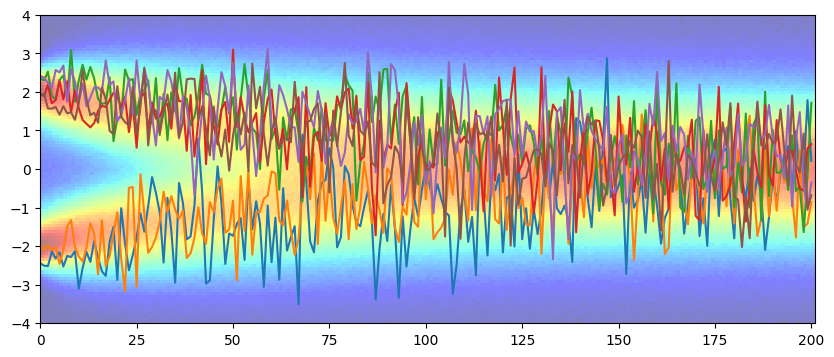

In [38]:
#evolution de qq chaines de Markov au cours de la diffusion:
# convergence de la loi initiale vers la loi normale

fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(track_fwd[:,1:7]);
ax.imshow(all_xk_bin.T,cmap='jet',
          norm=colors.PowerNorm(0.5,vmin=0, vmax=0.5), extent=[0,201,-4,4],
         alpha=0.5)
ax.set_aspect(10)

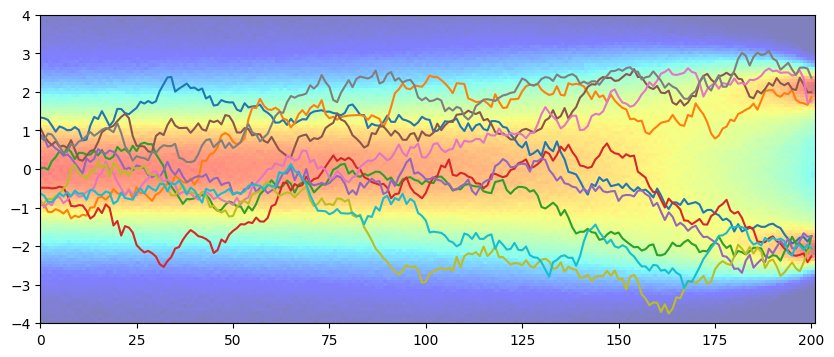

In [39]:
# evolution de qq chaines de Markov au cours de la génération (débruitage):
#  convergence de la loi normale vers la loi initiale
fig,ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(track_bwd);
ax.imshow(all_xk_bwd_bin.T,cmap='jet',
          norm=colors.PowerNorm(0.5,vmin=0, vmax=0.5), extent=[0,201,-4,4],
         alpha=0.5)
ax.set_aspect(10)